In [14]:
%load_ext autoreload
%autoreload 2
import sys
import os
import argparse
import logging
import shutil
import re
from PIL import Image
from skimage import io
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from auto_tqdm import tqdm
import torch
import torch.nn.functional as F
import torchvision.models as models
import torch.optim as optim
from torchvision.datasets import VisionDataset
from torchvision import transforms
import torch.backends.cudnn as cudnn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from utils import *
import augmentations
%matplotlib inline

DATA_DIR = '/data/amiratag/prostate'
MEM_DIR = '/home/amiratag/Projects/Prostate'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Functions

In [ ]:
def eval(args, model, eval_loader, num_eval_batches=None):
    
    if num_eval_batches is None:
        num_eval_batches = len(eval_loader)
    model.eval()
    counter = 0
    loss = 0
    total = 0
    with torch.no_grad():
        for batch_idx, images in enumerate(eval_loader):
            images = torch.cat(images, dim=0)
            images = images.to(args.device)
            features = model(images)
            logits, labels = simclr_criterion(args, features)
            loss += torch.nn.CrossEntropyLoss().to(args.device)(logits, labels).item()
            total += 1
            counter += 1
            if counter >= num_eval_batches:
                break
    loss /= total
    eval_data = dict(loss=loss)
    return eval_data

def simclr_criterion(args, features):
    
    labels = torch.cat([torch.arange(args.batch_size) for i in range(args.n_views)],
                   dim=0)
    labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float().to(args.device)
    features = F.normalize(features, dim=1)
    similarity_matrix = torch.matmul(features, features.T)
    mask = torch.eye(labels.shape[0], dtype=torch.bool).to(args.device)
    labels = labels[~mask].view(labels.shape[0], -1)
    similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)
    positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)
    negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)
    logits = torch.cat([positives, negatives], dim=1)
    labels = torch.zeros(logits.shape[0], dtype=torch.long).to(args.device)
    logits = logits / args.temperature
    
    return logits, labels

def train(args, model, train_loader, optimizer, epoch, epoch_size=None):
    
    if epoch_size is None:
        epoch_size = len(train_loader)
    model.train()
    train_metrics = []
    counter = 0
    for batch_idx, images in enumerate(train_loader):
        images = torch.cat(images, dim=0)
        images = images.to(args.device)
        features = model(images)
        logits, labels = simclr_criterion(args, features)
        loss = torch.nn.CrossEntropyLoss().to(args.device)(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_metrics.append(dict(
            epoch=epoch,
            loss=loss.item()))
        # print progress
        if batch_idx % args.log_interval == 0:
            logging.info(
                'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(images), epoch_size * args.batch_size,
                           100. * batch_idx / epoch_size, loss.item()))
        counter += 1
        if counter >= epoch_size:
            break
    return train_metrics

Arguments

In [2]:
parser = argparse.ArgumentParser(
    description='PyTorch TRADES Adversarial Training')


parser.add_argument('--model_dir', default='./simclr/translationrotation',
                    help='Directory of model for saving checkpoint')
parser.add_argument('--overwrite', action='store_true', default=False,
                    help='Cancels the run if an appropriate checkpoint is found')

# Logging and checkpointing
parser.add_argument('--log_interval', type=int, default=100,
                    help='Number of batches between logging of training status')
parser.add_argument('--save_freq', default=1, type=int,
                    help='Checkpoint save frequency (in epochs)')

# Generic training configs
parser.add_argument('--seed', type=int, default=1,
                    help='Random seed. '
                         'Note: fixing the random seed does not give complete '
                         'reproducibility. See '
                         'https://pytorch.org/docs/stable/notes/randomness.html')
parser.add_argument('--batch_size', type=int, default=128, metavar='N',
                    help='Input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=150, metavar='N',
                    help='Number of epochs to train. '
                         'Note: we arbitrarily define an epoch as a pass '
                         'through 50K datapoints. This is convenient for '
                         'comparison with standard CIFAR-10 training '
                         'configurations.')
parser.add_argument('--eval_freq', default=5, type=int,
                    help='Eval frequency (in epochs)')
parser.add_argument('--weight_decay', '--wd', default=1e-4, type=float)
parser.add_argument('--lr', type=float, default=0.05, metavar='LR',
                    help='Learning rate')
parser.add_argument('--lr_schedule', type=str, default='cosine',
                    choices=('trades', 'trades_fixed', 'cosine', 'wrn'),
                    help='Learning rate schedule')
parser.add_argument('--momentum', type=float, default=0.9, metavar='M',
                    help='SGD momentum')
parser.add_argument('--nesterov', action='store_true', default=True,
                    help='Use extragrdient steps')
parser.add_argument('--balanced', action='store_true', default=True,
                    help='Use balanced dataset')
parser.add_argument('--n_views', type=int, default=2,
                    help='Number of views in the contrastive learning')
parser.add_argument('--base_model', type=str, default='resnet34',
                    help='Use balanced dataset')
parser.add_argument('--out_dim', type=int, default=128,
                    help='Feature dimensionality')
parser.add_argument('--temperature', type=float, default=0.07,
                    help='Softmax temperature')


args = parser.parse_args('')

In [3]:
if args.overwrite:
    shutil.rmtree(args.model_dir)
if not os.path.exists(args.model_dir):
    os.makedirs(args.model_dir)
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(message)s",
    handlers=[
        logging.FileHandler(os.path.join(args.model_dir, 'training.log')),
        logging.StreamHandler()
    ])
logger = logging.getLogger()

logging.info('Robust self-training')
logging.info('Args: %s', args)

2021-03-01 10:22:29,377 | Robust self-training
2021-03-01 10:22:29,378 | Args: Namespace(balanced=True, base_model='resnet34', batch_size=128, epochs=150, eval_freq=5, log_interval=100, lr=0.05, lr_schedule='cosine', model_dir='./simclr/translationrotation', momentum=0.9, n_views=2, nesterov=True, out_dim=128, overwrite=False, save_freq=1, seed=1, temperature=0.07, weight_decay=0.0001)


In [4]:
args.balanced = False

Load dataset

In [6]:
## We assume background has already been removed, therefore we don't load class 0
classes = np.arange(1, 6).astype(str)
paths, labels = [], []
for cls in classes:
    new_paths = os.listdir(os.path.join(DATA_DIR, 'patches', cls))
    paths.extend([os.path.join(DATA_DIR, 'patches', cls, i) for i in new_paths])
    labels.extend([int(cls)] * len(new_paths))
paths, labels = np.array(paths), np.array(labels)
X_train, X_val, y_train, y_val = train_test_split(
    paths, labels, test_size=0.1, stratify=labels, random_state=0)
if args.balanced:
    X_train, y_train = balanced_dataset(X_train, y_train, min_size=3000000)
    X_val, y_val = balanced_dataset(X_val, y_val, min_size=300000)

In [7]:
cudnn.benchmark = True
use_cuda = torch.cuda.is_available()
torch.manual_seed(args.seed)
args.device = torch.device('cuda') if use_cuda else 'cpu'

In [8]:
s = 1
color_jitter = transforms.ColorJitter(0.2, 0.2, 0.1, 0.2)
simclr_transforms = transforms.Compose([
        augmentations.TranslateRotate(30, 30, size=224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomResizedCrop(size=224, scale=(0.5, 1.5), ratio=(0.9, 1.1)),
        transforms.RandomApply([color_jitter], p=0.8),
        transforms.RandomGrayscale(p=0.05),
        augmentations.GaussianBlur(kernel_size=int(0.1 * 224), sigma_min=0.01, sigma_max=1.0),
        transforms.ToTensor()
    ])

In [9]:
dataset = ContrastiveDataset(X_train, args.n_views, simclr_transforms)
val_dataset = ContrastiveDataset(X_val, args.n_views, simclr_transforms)
kwargs = {'num_workers': 32, 'pin_memory': True} if use_cuda else {}
train_loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=True, **kwargs)
val_loader = DataLoader(val_dataset, batch_size=args.batch_size, shuffle=False, **kwargs)

## Load trained model

In [11]:
model = ResNetSimCLR(args.base_model, args.out_dim)
if use_cuda:
    model = torch.nn.DataParallel(model).cuda()
optimizer = optim.SGD(model.parameters(), lr=args.lr,
                      momentum=args.momentum,
                      weight_decay=args.weight_decay,
                      nesterov=args.nesterov)
init_epoch = 0
train_df = pd.DataFrame()
eval_df = pd.DataFrame()
## Load existing checkpoints and logs
checkpoints = [i for i in os.listdir(args.model_dir) if '.pt' in i]
checkpoints_epoch_num = [int(re.search('epoch(\d+)', c).group(1)) for c in checkpoints]
if len(checkpoints_epoch_num):
    init_epoch = np.max(checkpoints_epoch_num)
    checkpoint = torch.load(os.path.join(args.model_dir, 'checkpoint-epoch{}.pt'.format(init_epoch)))
    state_dict = checkpoint.get('state_dict', checkpoint)
    model.load_state_dict(state_dict)
    opt_checkpoint = torch.load(os.path.join(args.model_dir, 'opt-checkpoint_epoch{}.tar'.format(init_epoch)))
    optimizer.load_state_dict(opt_checkpoint)
    logger.info('Loading checkpoint from epoch #{}'.format(init_epoch))
    train_df = pd.read_csv(os.path.join(args.model_dir, 'stats_train.csv'), index_col=0)
    train_df.drop(train_df.index[np.arange(init_epoch, len(eval_df))], inplace=True)
    eval_df = pd.read_csv(os.path.join(args.model_dir, 'stats_eval.csv'), index_col=0)
    eval_df.drop(eval_df.index[np.arange(init_epoch, len(eval_df))], inplace=True)
else:
    print('No checkpoint found. Random initialization!')

resnet34


2021-03-01 10:25:53,549 | Loading checkpoint from epoch #121


Train

In [12]:
epoch_size = 1000
for epoch in range(init_epoch+1, args.epochs + 1):
    
    lr = adjust_learning_rate(args, optimizer, epoch)
    logger.info('Setting learning rate to %g' % lr)
    train_data = train(args, model, train_loader, optimizer, epoch, epoch_size=epoch_size)
    train_df = train_df.append(pd.DataFrame(train_data), ignore_index=True)

    # evaluation on natural examples
    logging.info(120 * '=')
    if epoch % args.eval_freq == 0 or epoch == args.epochs:
        eval_data = {'epoch': int(epoch)}
        eval_data.update(
            eval(args, model, val_loader, num_eval_batches=100))
        eval_df = eval_df.append(pd.Series(eval_data), ignore_index=True)
        logging.info(120 * '=')

    # save stats
    train_df.to_csv(os.path.join(args.model_dir, 'stats_train.csv'))
    eval_df.to_csv(os.path.join(args.model_dir, 'stats_eval.csv'))
    
    if epoch % args.save_freq == 0 or epoch == args.epochs:
        torch.save(dict(
                        state_dict=model.state_dict()),
                   os.path.join(args.model_dir,
                                'checkpoint-epoch{}.pt'.format(epoch)))
        torch.save(optimizer.state_dict(),
                   os.path.join(args.model_dir,
                                'opt-checkpoint_epoch{}.tar'.format(epoch)))
        
    delete_old_ckpts(args.model_dir)

Train linear classifier on top of leanred representations

In [16]:
test_transofrms = transforms.Compose([transforms.ToPILImage(), transforms.ToTensor()])
val_dataset = CustomDataset(X_val, y_val, train=False, transform=test_transofrms)
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False, **kwargs)

In [63]:
model.eval()
counter = 0
f, l = [], []
with torch.no_grad():
    for X_batch, y_batch in tqdm(val_loader):
        X_batch = X_batch.to(args.device)
        features = model(X_batch)
        f.append(features.detach().cpu().numpy())
        l.append(y_batch.detach().cpu().numpy())
        if len(np.concatenate(l)) > 100000:
            break

In [19]:
a = np.concatenate(f, 0)
b = np.concatenate(l)
chosen_idxs = np.random.choice(len(a), 10000, replace=False)
a = a[chosen_idxs]
b = b[chosen_idxs]
a_train, a_test, b_train, b_test = train_test_split(a, b, test_size=int(0.1 * len(a)))
print(a.shape)

(10000, 128)


In [20]:
lr = LogisticRegression()
cross_val_score(lr, a, b, cv=5)

/home/amiratag/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/home/amiratag/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.htm

array([0.62  , 0.623 , 0.6315, 0.6285, 0.632 ])

In [21]:
lr.fit(a_train, b_train)

/home/amiratag/.local/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression()

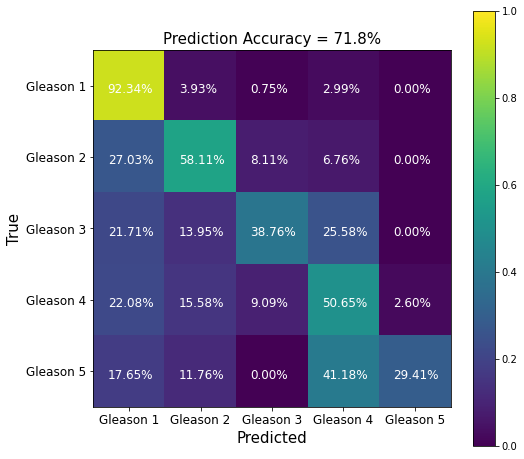

In [30]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(b_test, lr.predict(a_test))
normalized_cm = cm/np.sum(cm, -1, keepdims=True)


fig = plt.figure(figsize=(8, 8))
plt.imshow(normalized_cm, vmin=0., vmax=1)
plt.colorbar()
plt.xticks(np.arange(5), ['Gleason {}'.format(i) for i in range(1,6)], fontsize=12)
plt.yticks(np.arange(5), ['Gleason {}'.format(i) for i in range(1,6)], fontsize=12)
plt.xlabel('Predicted', fontsize=15)
plt.ylabel('True', fontsize=15)
plt.title('Prediction Accuracy = {0:.1f}%'.format(100 * np.mean(lr.predict(a_test) == b_test)), fontsize=15)
for i in range(5):
    for j in range(5):
        plt.annotate('{0:.2f}%'.format(100 * normalized_cm[i, j]), (j-0.3, i+0.1), color='white', fontsize=12)